### Import Libraries

In [1]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch
import torchvision
import torch.nn as nn

from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix

import torch.optim as optim
from torch.optim.lr_scheduler import MultiplicativeLR, ExponentialLR

import warnings
warnings.filterwarnings("ignore")

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.0+cpu  Device: cpu


In [4]:
raw_data = pd.read_csv('./PAMAP2_data.csv')
print(raw_data.shape)
raw_data.head()

(2872533, 54)


,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.008300,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.006577,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.003014,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,0.003175,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,0.012698,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0


In [5]:
# Define a function to clean data
def clean_data(data):
    # Remove certain columns
    data = data.drop(['timestamp'], axis=1)
    # Remove the orientation columns
    data = data.drop(['handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4'], axis=1)
    data = data.drop(['chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4'], axis=1)
    data = data.drop(['ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'], axis=1)

    # For the heart rate, fill missing values with previous timestamp's heart rate
    data['heartrate'] = data['heartrate'].fillna(method='ffill')

    # Normalize the data
    # data = (data - data.mean()) / data.std()
    # discard data with NaN values
    data = data.dropna()
    data = data.reset_index(drop=True)

    # disacrd data with activityID = 0
    data = data[data['activityID'] != 0]
    data = data.reset_index(drop=True)

    # Shuffle the data
    data = data.sample(frac=1).reset_index(drop=True)
    return data

In [6]:
data = clean_data(raw_data)
data.head()

,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,...,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3
0,7,105.0,30.6875,0.681304,-7.99134,5.00364,0.821884,-7.88287,5.12936,0.303203,...,-2.19933,13.01600,0.922074,-2.48521,0.542961,0.734533,1.761460,-44.5143,15.702900,-3.588820
1,5,114.0,32.5000,-12.363400,-9.61630,2.77390,-12.139000,-8.74324,2.47167,-1.158360,...,-7.91334,13.71750,2.307840,-7.29125,1.124360,1.160660,-4.188310,-35.1067,-20.852600,27.264200
2,16,103.0,34.1250,-8.150360,4.40777,4.82952,-9.188770,5.19330,6.00190,-0.057778,...,-2.63167,9.08124,1.571830,-2.26964,-0.008546,0.105185,-0.420047,-51.0284,0.075543,0.519526
3,1,75.0,33.6875,7.030280,2.44179,6.21817,7.205300,2.43254,6.51970,-0.015322,...,-3.59028,-0.39021,-9.230800,-3.28945,-0.027509,0.009574,-0.030275,-12.4488,23.598500,-4.402690
4,3,77.0,32.7500,-9.037240,2.34539,2.55244,-8.998920,2.44016,2.62516,-0.006869,...,-2.65366,9.56117,-0.545613,-2.31078,0.010785,0.006760,-0.014446,-10.5620,-8.225000,9.465100


In [7]:
y = data['activityID']
y = y.replace({1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 12: 7, 13: 8, 16: 9, 17: 10, 24: 11})
X = data.drop(['activityID'], axis=1)

print("Shape of X:", X.shape)
print("Shape of Y:", y.shape)

Shape of X: (1921431, 40)
Shape of Y: (1921431,)


In [8]:
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

In [9]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Split training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1296965, 40)
Shape of y_train: (1296965,)
Shape of X_val: (432322, 40)
Shape of y_val: (432322,)
Shape of X_test: (192144, 40)
Shape of y_test: (192144,)


In [10]:
class PAMAP2Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.long)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
batch_size = 512

train_dataset = PAMAP2Dataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = PAMAP2Dataset(X_val, y_val)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

test_dataset = PAMAP2Dataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [12]:
class Neural_Network(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, batchNorm = True, dropOut = True, dropOutProb=0.1):
        super(Neural_Network,self).__init__()
        self.layers = nn.ModuleList()
        
        # The input layer just holds the input data and no calculation is performed. Therefore, no activation function is used there.
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        if (batchNorm == True):
            self.layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        self.layers.append(nn.ReLU());
        if (dropOut == True):
            self.layers.append(nn.Dropout(p=dropOutProb))

        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            if (batchNorm == True):
                self.layers.append(nn.BatchNorm1d(hidden_sizes[i + 1]))
            self.layers.append(nn.ReLU())
            if (dropOut == True):
                self.layers.append(nn.Dropout(p=dropOutProb))

        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

In [13]:
class Trainer_Validator_Tester():
    def __init__(self, model, optimizer, criterion, trainloader, validationloader, testloader, lr_scheduler = None):
      self.model = model
      self.optimizer = optimizer
      self.criterion = criterion

      self.trainloader = trainloader
      self.validationloader = validationloader
      self.testloader = testloader

      self.lr_scheduler = lr_scheduler

      self.train_loss = []
      self.validation_loss = []
      self.test_loss = []

      self.test_accuracy = []
      self.validation_accuracy = []
      self.train_accuracy = []

    def train_and_validate(self, epochs):
      for epoch in range(1, epochs + 1):
        self.train(epoch);
        self.validate();

        # Use lr_scheduler
        if self.lr_scheduler is not None:
            self.lr_scheduler.step()
        
    def train(self, epoch):
        # Set model to training mode
        self.model.train()

        # Loop over each batch from the training set
        for batch_idx, (data, target) in enumerate(self.trainloader):
            # Copy data to GPU if needed
            data, target = data.to(device), target.to(device)
            # Zero gradient buffers
            self.optimizer.zero_grad() 
            # Pass data through the network
            output = self.model(data)
            # Calculate loss
            loss = criterion(output, target)
            # Backpropagate
            loss.backward()
            # Update weights
            self.optimizer.step()
            
            lr=optimizer.param_groups[0]["lr"]
        print('Train Epoch: {}\tLearning Rate: {}'.format(epoch, lr))
          
    def validate(self):
      # Set model to evaluation mode
      self.model.eval()

      # Variables to monitor validation loss and accuracy
      validation_loss = 0.
      correct = 0.
      total = 0.

      with torch.no_grad():
          # Loop over each batch from the validation set
          for batch_idx, (data, target) in enumerate(self.validationloader):
              # Copy data to GPU if needed
              data, target = data.to(device), target.to(device)
              # Pass data through the network
              output = self.model(data)
              # Calculate loss
              loss = criterion(output, target)
              # Update average validation loss 
              validation_loss = validation_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - validation_loss))
              # Get the index of the max log-probability
              pred = output.data.max(1, keepdim=True)[1]
              # Compare predictions to true label
              correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
              total += data.size(0)

      self.validation_loss.append(validation_loss)
      self.validation_accuracy.append(100. * correct / total)

      print('Validation Loss: {:.6f}, Accuracy: {}/{} ({:.3f}%)\n'.format(validation_loss, correct, total, 100. * correct / total))
    
    def test(self):
      # Set model to evaluation mode
      self.model.eval()

      # Variables to monitor test loss and accuracy
      test_loss = 0.
      correct = 0.
      total = 0.

      with torch.no_grad():
          # Loop over each batch from the testing set
          for batch_idx, (data, target) in enumerate(self.testloader):
              # Copy data to GPU if needed
              data, target = data.to(device), target.to(device)
              # Pass data through the network
              output = self.model(data)
              # Calculate loss
              loss = criterion(output, target)
              # Update average test loss 
              test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
              # Get the index of the max log-probability
              pred = output.data.max(1, keepdim=True)[1]
              # Compare predictions to true label
              correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
              total += data.size(0)

      self.test_loss.append(test_loss)
      self.test_accuracy.append(100. * correct / total)
      # self.f1_score.append(f1_score(target.data.cpu().numpy(), pred.cpu().numpy(), average='macro'))

      print('Test Loss: {:.6f}, Accuracy: {}/{} {:.3f}%'.format(test_loss, correct, total, 100. * correct / total))
      print()

    def plot_loss_and_accuracy(self):
      plt.figure(figsize=(15,5))
      plt.subplot(1,2,1)
      plt.plot(range(1,len(self.validation_loss)+1),self.validation_loss)
      plt.title('Model Loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')

      plt.subplot(1,2,2)
      plt.plot(range(1,len(self.validation_accuracy)+1),self.validation_accuracy)
      plt.title('Model Accuracy')
      plt.ylabel('Accuracy (%)')
      plt.xlabel('Epoch')
      plt.show()

12
Neural_Network(
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=12, bias=True)
  )
)
Training the model...
Train Epoch: 1	Learning Rate: 0.01
Validation Loss: 0.693465, Accuracy: 353122.0/432322.0 (81.680%)

Train Epoch: 2	Learning Rate: 0.01
Validation Loss: 0.491956, Accuracy: 374619.0/432322.0 (86.653%)

Train Epoch: 3	Learning Rate: 0.01
Validation Loss: 0.401475, Accuracy: 384140.0/432322.0 (88.855%)

Train Epoch: 4	Learning Rate: 0.01
Validation Loss: 0.349250, Accuracy: 390052.0/432322.0 (90.223%)

Train Epoch: 5	Learning Rate: 0.01
Validation Loss: 0.313932, Accuracy: 393846.0/432322.0 (91.100%)

Train Epoch: 6	Learning Rate: 0.01
Validation Loss: 0.287784, Accuracy: 396550.0/432322.0 (91.726%)

Train Epoch: 7	Learning Rate: 0.01
Validation Loss: 0.267145, Accuracy: 398642.0/432322.0 (92.210%)

Train Epoch: 8	Learning Rate: 0.01
Validation Loss: 0.250189, Accuracy: 400845.0/432

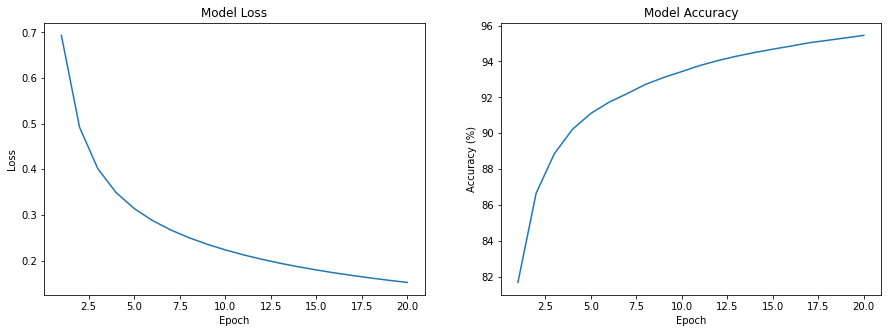

In [14]:
# SGD Optmizer, No drouput, No batchnorm
input_size = X_train.shape[1]
hidden_size = [256]
output_size = 12
print(output_size)

model = Neural_Network(input_size, hidden_size, output_size, dropOut = False, batchNorm = False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print(model)

tnt = Trainer_Validator_Tester(model, optimizer, criterion, train_loader, validation_loader, test_loader)

print("Training the model...")
tnt.train_and_validate(20)
print("Training Completed...")
print()
print("Testing the model...")
tnt.test()
print("Testing Completed...")

tnt.plot_loss_and_accuracy()

12
Neural_Network(
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=12, bias=True)
  )
)
Training the model...
Train Epoch: 1	Learning Rate: 0.01
Validation Loss: 0.680672, Accuracy: 354843.0/432322.0 (82.078%)

Train Epoch: 2	Learning Rate: 0.01
Validation Loss: 0.490239, Accuracy: 373675.0/432322.0 (86.434%)

Train Epoch: 3	Learning Rate: 0.01
Validation Loss: 0.402455, Accuracy: 383512.0/432322.0 (88.710%)

Train Epoch: 4	Learning Rate: 0.01
Validation Loss: 0.351222, Accuracy: 389592.0/432322.0 (90.116%)

Train Epoch: 5	Learning Rate: 0.01
Validation Loss: 0.316938, Accuracy: 393071.0/432322.0 (90.921%)

Train Epoch: 6	Learning Rate: 0.01
Validation Loss: 0.291445, Accuracy: 395723.0/432322.0 (91.534%)

Train Epoch: 7	Learning Rate: 0.01
Validation Loss: 0.271415, Accuracy: 397882.0/432322.0 (92.034%)

Train Epoch: 8	Learning Rate: 0.01
Validation

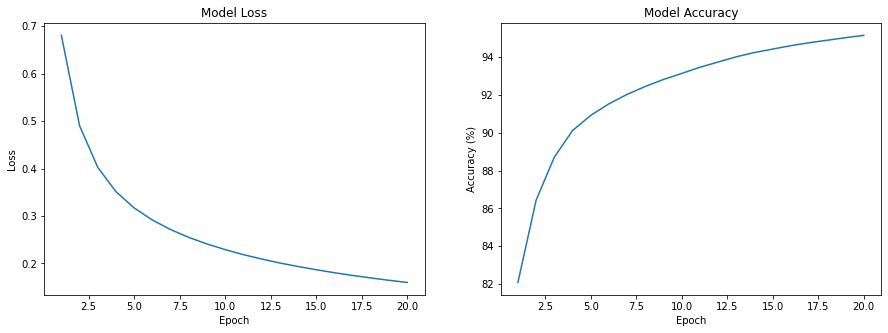

In [15]:
# SGD Optimizer, No BatchNorm
input_size = X_train.shape[1]
hidden_size = [256]
output_size = 12
print(output_size)

model = Neural_Network(input_size, hidden_size, output_size, batchNorm = False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print(model)

tnt = Trainer_Validator_Tester(model, optimizer, criterion, train_loader, validation_loader, test_loader)

print("Training the model...")
tnt.train_and_validate(20)
print("Training Completed...")
print()
print("Testing the model...")
tnt.test()
print("Testing Completed...")

tnt.plot_loss_and_accuracy()

12
Neural_Network(
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=256, out_features=12, bias=True)
  )
)
Training the model...
Train Epoch: 1	Learning Rate: 0.01
Validation Loss: 0.500542, Accuracy: 373579.0/432322.0 (86.412%)

Train Epoch: 2	Learning Rate: 0.01
Validation Loss: 0.359467, Accuracy: 388897.0/432322.0 (89.955%)

Train Epoch: 3	Learning Rate: 0.01
Validation Loss: 0.295105, Accuracy: 395483.0/432322.0 (91.479%)

Train Epoch: 4	Learning Rate: 0.01
Validation Loss: 0.256191, Accuracy: 399891.0/432322.0 (92.498%)

Train Epoch: 5	Learning Rate: 0.01
Validation Loss: 0.228956, Accuracy: 403344.0/432322.0 (93.297%)

Train Epoch: 6	Learning Rate: 0.01
Validation Loss: 0.208199, Accuracy: 406145.0/432322.0 (93.945%)

Train Epoch: 7	Learning Rate: 0.01
Validation Loss: 0.19

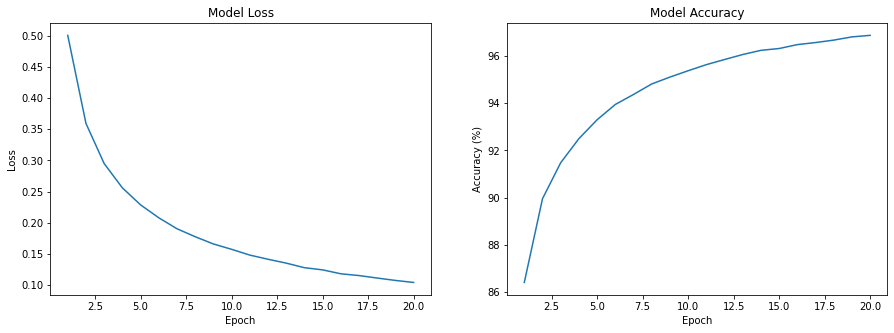

In [16]:
# SGD Optimizer
input_size = X_train.shape[1]
hidden_size = [256]
output_size = 12
print(output_size)

model = Neural_Network(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print(model)

tnt = Trainer_Validator_Tester(model, optimizer, criterion, train_loader, validation_loader, test_loader)

print("Training the model...")
tnt.train_and_validate(20)
print("Training Completed...")
print()
print("Testing the model...")
tnt.test()
print("Testing Completed...")

tnt.plot_loss_and_accuracy()

12
Neural_Network(
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=512, out_features=12, bias=True)
  )
)
Training the model...
Train Epoch: 1	Learning Rate: 0.01
Validation Loss: 0.023118, Accuracy: 428474.0/432322.0 (99.110%)

Train Epoch: 2	Learning Rate: 0.01
Validation Loss: 0.016044, Accuracy: 429817.0/432322.0 (99.421%)

Train Epoch: 3	Learning Rate: 0.01
Validation Loss: 0.012131, Accuracy: 430479.0/432322.0 (99.574%)

Train Epoch: 4	Learning Rate: 0.01
Validation Loss: 0.008102, Accuracy: 431032.0/432322.0 (99.702%)

Train Epoch: 5	Learning Rate: 0.01
Validation Loss:

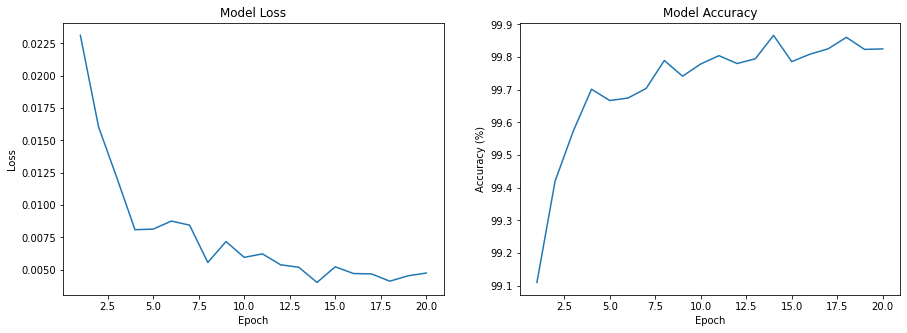

In [17]:
# adam optimizer
input_size = X_train.shape[1]
hidden_size = [256, 512]
output_size = 12
print(output_size)

model = Neural_Network(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model)

tnt = Trainer_Validator_Tester(model, optimizer, criterion, train_loader, validation_loader, test_loader)

print("Training the model...")
tnt.train_and_validate(20)
print("Training Completed...")
print()
print("Testing the model...")
tnt.test()
print("Testing Completed...")

tnt.plot_loss_and_accuracy()

12
Neural_Network(
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=512, out_features=12, bias=True)
  )
)
Training the model...
Train Epoch: 1	Learning Rate: 0.01
Validation Loss: 0.023705, Accuracy: 428609.0/432322.0 (99.141%)

Train Epoch: 2	Learning Rate: 0.009000000000000001
Validation Loss: 0.012271, Accuracy: 430494.0/432322.0 (99.577%)

Train Epoch: 3	Learning Rate: 0.008100000000000001
Validation Loss: 0.011750, Accuracy: 430492.0/432322.0 (99.577%)

Train Epoch: 4	Learning Rate: 0.007290000000000001
Validation Loss: 0.008343, Accuracy: 431062.0/432322.0 (99.709%)

Tra

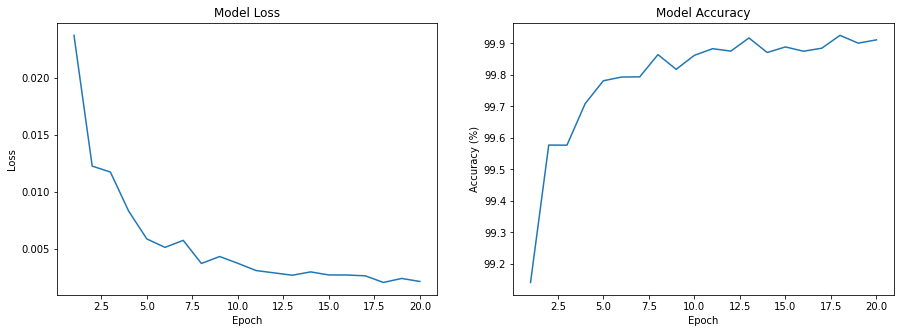

In [18]:
# Exponential LR on adam optimizer

input_size = X_train.shape[1]
hidden_size = [256, 512]
output_size = 12
print(output_size)

model = Neural_Network(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.9)
print(model)

tnt = Trainer_Validator_Tester(model, optimizer, criterion, train_loader, validation_loader, test_loader, lr_scheduler = scheduler)

print("Training the model...")
tnt.train_and_validate(20)
print("Training Completed...")
print()
print("Testing the model...")
tnt.test()
print("Testing Completed...")

tnt.plot_loss_and_accuracy()